In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from plotly.offline import plot

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

from utils import save_plotly_figure_as_html
from ex_01_read_data import get_welding_data



In [18]:
data_path = Path("data/Welding/data.csv")

## Exercise 2.1: Dataset Statistics Analysis

In this exercise, we'll calculate and present comprehensive descriptive statistics for the welding dataset. This statistical overview will help us understand the fundamental characteristics of our data before visualization or modeling.

1. Calculate the class distribution to understand data balance
2. Count samples per experiment to assess data volume across experimental conditions
3. Determine min/max values for voltage and current to understand the range of measurements
4. Calculate mean and standard deviation to assess central tendency and variability
5. Find median values to identify central points unaffected by outliers

In [19]:
data, labels, exp_ids = get_welding_data(data_path)

In [20]:
# 1. Klassenverteilung (je Sample ein Label)
class_counts = pd.Series(labels).value_counts().sort_index()
print("1) Klassenverteilung:")
print(class_counts)

# 2. Anzahl Samples pro Experiment
exp_counts = pd.Series(exp_ids).value_counts().sort_index()
print("\n2) Samples pro Experiment:")
print(exp_counts)

# 3. Min/Max-Werte über alle Messpunkte hinweg
#    Wir „flatten“ Samples und Timesteps, getrennt für current und voltage
curr_values = data[:, :, 0].ravel()
volt_values = data[:, :, 1].ravel()

print(f"\n3) Spannung: min = {volt_values.min():.3f}, max = {volt_values.max():.3f}")
print(f"   Strom:     min = {curr_values.min():.3f}, max = {curr_values.max():.3f}")

# 4. Mittelwert & Standardabweichung
print(f"\n4) Spannung: mean = {volt_values.mean():.3f}, std = {volt_values.std(ddof=1):.3f}")
print(f"   Strom:     mean = {curr_values.mean():.3f}, std = {curr_values.std(ddof=1):.3f}")

# 5. Medianwerte
print(f"\n5) Spannung: median = {np.median(volt_values):.3f}")
print(f"   Strom:     median = {np.median(curr_values):.3f}")


1) Klassenverteilung:
0    90746
1    67219
Name: count, dtype: int64

2) Samples pro Experiment:
1    35521
2    17913
3    46768
4    57763
Name: count, dtype: int64

3) Spannung: min = 0.074, max = 101.485
   Strom:     min = -1.181, max = 614.154

4) Spannung: mean = 22.037, std = 6.025
   Strom:     mean = 173.456, std = 180.841

5) Spannung: median = 20.841
   Strom:     median = 68.588


## Exercise 2.2: Current and Voltage Distribution Visualization

In this exercise, we'll create interactive boxplots to visualize and compare the distributions of voltage and current measurements in the welding data. Boxplots will help us identify central tendencies, spread, and potential outliers in our measurements.

1. Create side-by-side boxplots for voltage and current using Plotly
2. Display key statistics (median, quartiles, etc.) in a visual format in the plot
3. Enable interactive exploration of the distributions
4. Save the visualization for future reference

In [21]:
data, labels, exp_ids = get_welding_data(data_path, n_samples=10_000)

pio.renderers.default = "png"

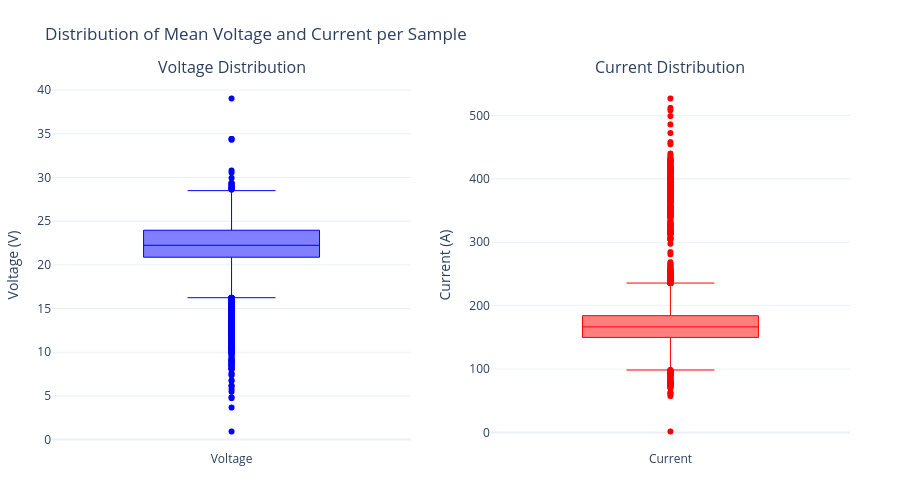

• plots-HTML: plots/ex_02/voltage_current_distribution.html
• root-HTML:  voltage_current_distribution.html
• PNG:        plots/ex_02/voltage_current_distribution.png


In [22]:
# --- Pfade & Ordner ---
data_path     = Path("data/Welding/data.csv")
plot_folder   = Path("plots/ex_02")
root_folder   = Path(".")
html_filename = "voltage_current_distribution.html"

plot_folder.mkdir(parents=True, exist_ok=True)

html_save_plot = plot_folder / html_filename
html_save_root = root_folder  / html_filename
png_save_plot  = plot_folder / "voltage_current_distribution.png"

# --- Daten laden ---
data, labels, exp_ids = get_welding_data(data_path, n_samples=10_000)

# --- Mittelwerte berechnen pro Sample ---
mean_currents = data[:, :, 0].mean(axis=1)
mean_voltages = data[:, :, 1].mean(axis=1)

# --- Subplots mit 2 Boxplots erzeugen ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Voltage Distribution", "Current Distribution"]
)

# --- Voltage Boxplot ---
fig.add_trace(
    go.Box(
        y=mean_voltages,
        name="Voltage",
        boxpoints="outliers",
        marker_color="blue",
        line=dict(width=1)
    ),
    row=1, col=1
)

# --- Current Boxplot ---
fig.add_trace(
    go.Box(
        y=mean_currents,
        name="Current",
        boxpoints="outliers",
        marker_color="red",
        line=dict(width=1)
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Distribution of Mean Voltage and Current per Sample",
    width=900,
    height=500,
    template="plotly_white",
    margin=dict(t=80, l=50, r=50, b=50),
    showlegend=False,
    yaxis=dict(title="Voltage (V)"),
    yaxis2=dict(title="Current (A)")
)

# --- Speichern ---
save_plotly_figure_as_html(fig, html_save_plot)
fig.write_html(str(html_save_root), include_plotlyjs="cdn")
fig.write_image(str(png_save_plot))

# --- Anzeige im Notebook (PNG-Renderer) ---
fig.show(renderer="png")

print(f"• plots-HTML: {html_save_plot}")
print(f"• root-HTML:  {html_save_root}")
print(f"• PNG:        {png_save_plot}")

## Exercise 2.3: Time-Series Sequence Visualization

In this exercise, we'll implement functions to visualize the time-series patterns of welding cycles. These visualizations will help us understand the temporal relationships between voltage and current during the welding process and identify patterns associated with quality outcomes.

1. Create dual-axis plots showing voltage and current over time (10 welding cycles -> sequence_length=10) using matplotlib
2. Implement clear legends and labels for data interpretation
3. Enable saving of visualizations for reporting and comparison

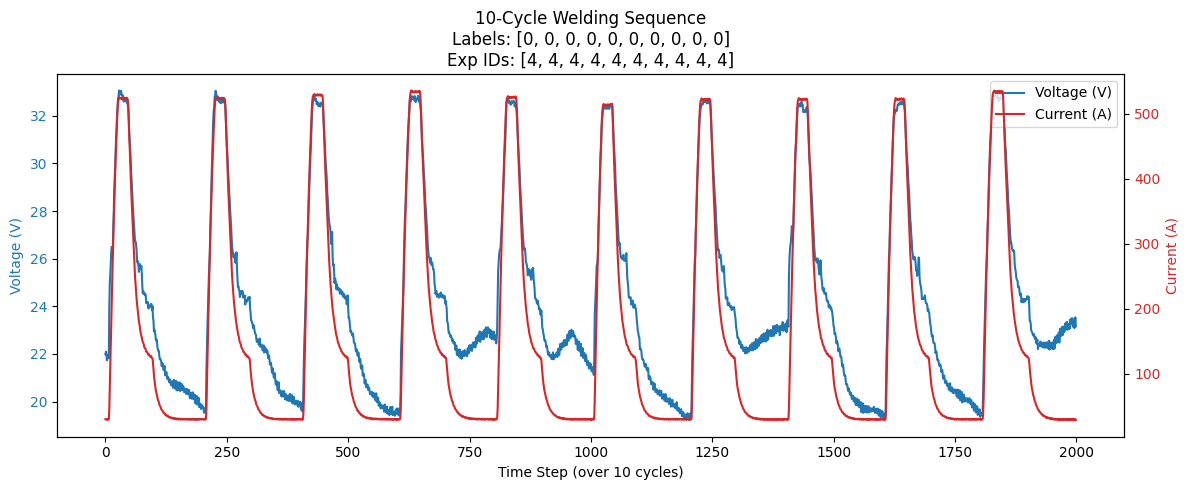

PosixPath('plots/ex_02/welding_sample.png')

In [23]:
# Pfade definieren
data_path = Path("data/Welding/data.csv")
plot_path = Path("plots/ex_02")
plot_path.mkdir(parents=True, exist_ok=True)
save_path = plot_path / "welding_sample.png"

# Daten laden: 100 Sequenzen, jede Sequenz = 10 Zyklen, return_sequences=True
data_seq, labels_seq, exp_ids_seq = get_welding_data(
    data_path, 
    n_samples=100, 
    return_sequences=True, 
    sequence_length=10
)

# Wähle die erste Sequenz (als Beispiel)
flat_sequence = data_seq[0]  # Shape: (sequence_length * timesteps, 2)
seq_len = 10
timesteps = flat_sequence.shape[0] // seq_len
features = flat_sequence.shape[1]  # sollte 2 sein

# Reshape zurück in (10, timesteps, 2)
sequence = flat_sequence.reshape(seq_len, timesteps, features)

# Labels und Exp IDs der Sequenz
label_sequence = labels_seq[0]    # Shape: (10,)
exp_id_sequence = exp_ids_seq[0]  # Shape: (10,)

# Plot
t = np.arange(sequence.shape[0] * sequence.shape[1])

fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

# Voltage (Feature 1)
volt_flat = sequence[:,:,1].ravel()
ax1.plot(t, volt_flat, color="tab:blue", label="Voltage (V)")
ax1.set_ylabel("Voltage (V)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Current (Feature 0)
curr_flat = sequence[:,:,0].ravel()
ax2.plot(t, curr_flat, color="tab:red", label="Current (A)")
ax2.set_ylabel("Current (A)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

ax1.set_xlabel("Time Step (over 10 cycles)")
ax1.set_title(f"10-Cycle Welding Sequence\nLabels: {label_sequence.tolist()}\nExp IDs: {exp_id_sequence.tolist()}")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()

# Ausgabe des Speicherpfads
save_path

## Exercise 2.4: Interactive Time-Series Visualization with Plotly

In this exercise, we'll create enhanced interactive visualizations of welding samples using Plotly. These interactive plots will provide more advanced exploration capabilities for analyzing the time-series patterns.

1. Create interactive plots with dual y-axes for voltage and current
2. Implement time-based range sliders for detailed exploration
3. Add unified tooltips for precise data reading
4. Display quality metrics in the plot title
5. Save interactive visualizations as HTML for sharing

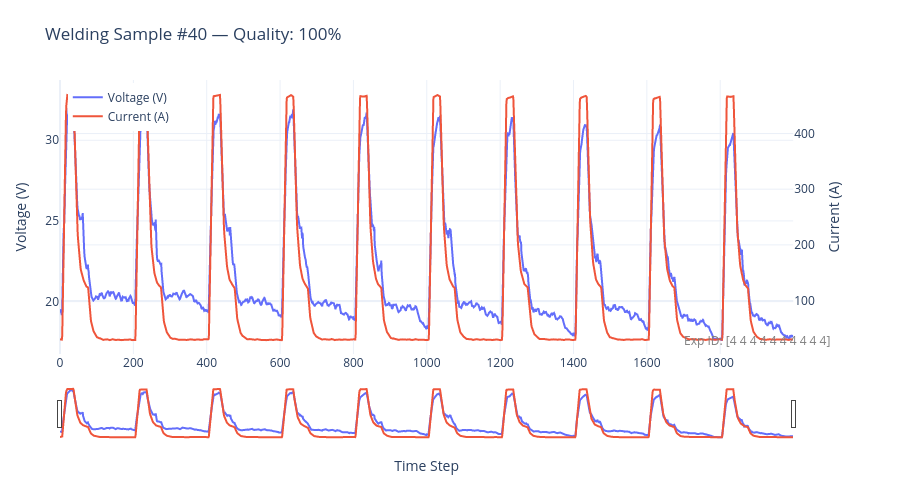

In [24]:
def create_plotly_plot(
    data: np.ndarray,
    labels: np.ndarray,
    exp_ids: np.ndarray = None
) -> go.Figure:
    """
    Create an interactive Plotly visualization of a random welding sample.

    Args:
        data (np.ndarray): Array of shape (n_samples, timesteps, 2) or
                           (n_windows, seq_len*timesteps, 2)
        labels (np.ndarray): Array of shape (n_samples,) or (n_windows,)
        exp_ids (np.ndarray, optional): experiment IDs, same length as labels

    Returns:
        go.Figure: Interactive dual-axis Plotly figure
    """
    # 1) Pick a random index
    idx = np.random.randint(0, data.shape[0])
    sample = data[idx]        # shape = (L, 2)
    L = sample.shape[0]
    t = np.arange(L)

    # 2) Compute quality metric (if label is 0/1, show percent good)
    quality = f"{int(100 * np.mean(labels[idx]))}%" if labels.ndim > 1 else str(labels[idx])

    # 3) Build figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Voltage trace
    fig.add_trace(
        go.Scatter(
            x=t,
            y=sample[:, 1],
            mode="lines",
            name="Voltage (V)",
            hovertemplate="t=%{x}<br>V=%{y:.2f} V"
        ),
        secondary_y=False
    )

    # Current trace
    fig.add_trace(
        go.Scatter(
            x=t,
            y=sample[:, 0],
            mode="lines",
            name="Current (A)",
            hovertemplate="t=%{x}<br>I=%{y:.2f} A"
        ),
        secondary_y=True
    )

    # 4) Layout with range slider & unified tooltips
    fig.update_layout(
        title=f"Welding Sample #{idx+1} — Quality: {quality}",
        xaxis=dict(
            title="Time Step",
            rangeslider=dict(visible=True),
            type="linear"
        ),
        yaxis=dict(title="Voltage (V)"),
        yaxis2=dict(title="Current (A)"),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template="plotly_white",
        width=900, height=500,
        margin=dict(l=60, r=60, t=80, b=60)
    )

    # 5) Optionally annotate experiment ID
    if exp_ids is not None:
        fig.add_annotation(
            text=f"Exp ID: {exp_ids[idx]}",
            xref="paper", yref="paper",
            x=0.99, y=0.01,
            showarrow=False,
            font=dict(size=12, color="gray"),
            align="right"
        )

    return fig

# --- Usage example for Exercise 2.4 ---
from ex_01_read_data import get_welding_data
from pathlib import Path

data_path = Path("data/Welding/data.csv")
plot_path = Path("plots/ex_02")
plot_path.mkdir(parents=True, exist_ok=True)

# load sequences if desired, or raw samples:
data, labels, exp_ids = get_welding_data(
    data_path, n_samples=100, return_sequences=True, sequence_length=10
)

fig = create_plotly_plot(data, labels, exp_ids)
save_plotly_figure_as_html(fig, plot_path / "welding_samples.html")
fig.show(renderer="png")

## Exercise 2.5: Multiple Sample Comparison

In this exercise, we'll generate and compare visualizations from multiple random welding samples. This comparison will help us identify common patterns and variations across different welding cycles.
 

1. Generate multiple random sample visualizations using matplotlib of single welding cycles
2. Create dual-axis plots showing voltage and current over time
3. Implement clear legends and labels for data interpretation
4. Save each visualization for comparison

In [ ]:
# Stichproben-Daten laden
data, labels, exp_ids = get_welding_data(
    data_path,
    n_samples=100,
    return_sequences=True,
    sequence_length=10
)

# Mehrere zufällige Plots speichern
for i in range(5):
    fig = create_plotly_plot(data, labels)
    html_file = plot_path / f"welding_sample_{i+1}.html"
    save_plotly_figure_as_html(fig, html_file)
    

NameError: name 'plot_random_sample' is not defined